In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn import metrics
from sklearn.metrics import f1_score
from shapely.affinity import translate
import shapely.wkb as wkb
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib_venn import venn3
import xgboost as xgb
import shap
import h3

from conflation.alignment import correct_local_shift
from conflation.feateng import calculate_matching_features

In [2]:
pd.options.display.max_columns = None

## Data

In [77]:
gdf_gov = gpd.read_parquet('data/aaai/buildings-gov.parquet')
gdf_osm = gpd.read_parquet('data/aaai/buildings-osm.parquet')
gdf_msft = gpd.read_parquet('data/aaai/buildings-msft.parquet')
df_pairs = pd.read_parquet('data/aaai/matching-pairs.parquet') 


## Util functions

#### Matching utils

In [10]:
XGBOOST_PARAMS = {
    "tree_method": "hist",
    "objective": "binary:logistic"
}
HYPERPARAMETERS = {
    "colsample_bytree": 0.7,
    "subsample": 0.7,
}

def predict_match(model_path: str, candidate_pairs: pd.DataFrame) -> pd.DataFrame:
    """
    Predicts whether pairs of geometries match using a pre-trained XGBoost model.
    """
    model = xgb.XGBClassifier(random_state=42, **HYPERPARAMETERS, **XGBOOST_PARAMS)
    model.load_model(model_path)

    fts = model.get_booster().feature_names
    X = candidate_pairs[fts]

    return model.predict(X).astype(bool)


def compute_ioa(geom1, geom2):
    return geom1.intersection(geom2).area / geom1.area


def compute_iosa(geom1, geom2):
    return geom1.intersection(geom2).area / np.minimum(geom1.area, geom2.area)


def compute_iou(geom1, geom2):
    intersection = geom1.intersection(geom2).area
    union = geom1.union(geom2).area
    iou = intersection / union
    iou = iou.fillna(0)  # mitigate devision by zero

    return iou


def compute_aligned_iou(geoms1, geoms2):
    aligned_geoms2 = gpd.GeoSeries([_align_centroids(g1, g2) for g1, g2 in zip(geoms1, geoms2)], index=geoms1.index, crs=geoms1.crs)
    aligned_iou = compute_iou(geoms1, aligned_geoms2)

    return aligned_iou


def count_adjacent_buildings(buildings, other_buildings):
    """For each building, calculate the number of other buildings that intersect it"""
    existing_building_idx, _ = other_buildings.sindex.query(buildings.geometry, predicate='intersects')
    existing_building_ids = buildings.index[existing_building_idx]
    n_adjacent = pd.Series(existing_building_ids).value_counts()

    return n_adjacent


def intersecting(gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame):
    """For each building, check if it overlaps with any building in the other dataset."""
    _, idx1 = gdf1.sindex.query(gdf2.geometry, predicate="intersects")
    idx1 = np.unique(idx1)
    mask = np.zeros(len(gdf1), dtype=bool)
    mask[idx1] = True

    return mask


def intersecting_above(gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame, threshold: float):
    """
    For each building in gdf1, check if it overlaps with any building in gdf2
    above a certain threshold of intersection area.
    """
    idx2, idx1 = gdf1.sindex.query(gdf2.geometry, predicate="intersects")
    geom1 = gdf1.iloc[idx1].geometry
    geom2 = gdf2.iloc[idx2].geometry
    intersection = geom1.intersection(geom2, align=False).area / geom1.area
    idx1 = idx1[intersection >= threshold]

    idx1 = np.unique(idx1)
    mask = np.zeros(len(gdf1), dtype=bool)
    mask[idx1] = True

    return mask


def _align_centroids(geom1, geom2):
    c1 = geom1.centroid
    c2 = geom2.centroid
    
    # Compute translation distances
    dx = c1.x - c2.x
    dy = c1.y - c2.y
    
    # Apply translation to geom2
    return translate(geom2, xoff=dx, yoff=dy)

#### Preprocessing utils

In [99]:
def drop_buildings_elsewhere(
    gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame, pairs: pd.DataFrame
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Remove buildings away from the candidate pairs.
    Buildings within h3 grid cell and direct neighboring cells are kept.
    """
    nbh1 = pairs["id_existing"].map(gdf1["neighborhood"])
    nbh2 = pairs["id_new"].map(gdf2["neighborhood"])
    nbh = pd.concat([nbh1, nbh2]).unique()
    nbh_w_neighbors = _h3_disk(nbh, k=1)

    gdf1 = gdf1[gdf1["neighborhood"].isin(nbh_w_neighbors)]
    gdf2 = gdf2[gdf2["neighborhood"].isin(nbh_w_neighbors)]

    return gdf1, gdf2


def _h3_disk(h3_indices: list[str], k: int) -> list[str]:
    """
    Determines all nearby cells for a list of h3 indices within k grid distance.
    """
    return np.unique(np.ravel([h3.grid_disk(idx, k) for idx in h3_indices]))

#### Plotting utils

In [ ]:
def plot_neighborhood_map(ax, existing_buildings, new_buildings, candidate_pair, size, plot_aligned_geometry=False):
    # Pair of interest
    existing_id, new_id = candidate_pair['id_existing'],  candidate_pair['id_new']
    centroid = new_buildings.loc[[new_id]].geometry.centroid.values[0]

    # Neighbors
    existing_neighbors = _within(existing_buildings, centroid, dis=size).copy()
    new_neighbors = _within(new_buildings, centroid, dis=size).copy()

    # Highlight pair of interest
    existing_neighbors['highlight_id'] = existing_id
    new_neighbors['highlight_id'] = new_id

    # Plot
    existing_neighbors.plot(ax=ax, **_get_plot_kwargs(existing_neighbors, 'skyblue', 'steelblue'))
    new_neighbors.plot(ax=ax, **_get_plot_kwargs(new_neighbors, 'coral', 'red'))

    if plot_aligned_geometry:
        gpd.GeoSeries([candidate_pair['geometry_new']]).plot(ax=ax, color='none', edgecolor='gray')

    ax.set_title(f"Neighborhood View for Pair: {existing_id} & {new_id}", fontsize=10)
    ax.set_axis_off()


def plot_map_grid(candidate_pairs, existing_buildings, new_buildings, metrics=None, n_cols=4, max_display=20, title=None, **kwargs):
    n = min(max_display, len(candidate_pairs))
    candidate_pairs = candidate_pairs.sample(n, random_state=42)
    n_rows = (n + n_cols - 1) // n_cols  # ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i in range(n):
        ax = axes[i]
        candidate_pair = candidate_pairs.iloc[i]
        plot_neighborhood_map(ax, existing_buildings, new_buildings, candidate_pair, 30, **kwargs)

        # Title of subplots
        subtitle = f"Candidate Pair {i}"
        if metrics:
            subtitle += '\n(' + ', '.join([f"{metric}: {candidate_pair[metric]:.2f}" for metric in metrics]) + ')'
        ax.set_title(subtitle, fontsize=9)

    # Hide unused axes
    for j in range(n, len(axes)):
        axes[j].axis('off')

    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor='skyblue', edgecolor='steelblue', linewidth=2.5, alpha=0.4, label='Candidate Existing'),
        Rectangle((0, 0), 1, 1, facecolor='coral', edgecolor='red', linewidth=2.5, alpha=0.2, label='Candidate New'),
        Rectangle((0, 0), 1, 1, facecolor='skyblue', edgecolor='skyblue', linewidth=1, alpha=0.2, label='Other Existing Buildings'),
        Rectangle((0, 0), 1, 1, facecolor='coral', edgecolor='coral', linewidth=1, alpha=0.2, label='Other New Buildings'),
    ]
    fig.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.01),
        fontsize=10,
        ncol=4,
        frameon=True,
        borderpad=0.5,
    )

    if title:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()


def _within(gdf, loc, dis):
    """
    Find all buildings within a certain distance from a given point.
    """
    idx = gdf.sindex.query(loc, predicate="dwithin", distance=dis)

    return gdf.iloc[idx]


def _get_plot_kwargs(gdf, base_color, highlight_color):
    is_highlighted = gdf.index == gdf['highlight_id']

    return {
        'edgecolor': np.where(is_highlighted, highlight_color, base_color),
        'facecolor': base_color,
        'linewidth': np.where(is_highlighted, 2.5, 1),
        'alpha': np.where(is_highlighted, 0.2 if base_color == 'coral' else 0.4, 0.2),
        'linestyle': np.where(is_highlighted, '--' if base_color == 'coral' else '-', '-'),
    }

## Preprocessing

In [ ]:
conflation_pairs = {
    'gov-osm': (gdf_gov, gdf_osm),
    'gov-msft': (gdf_gov, gdf_msft),
    'osm-msft': (gdf_osm, gdf_msft)
}
matched_pairs = []

for name, (gdf1, gdf2) in conflation_pairs.items():
    print(f"(1) Loading candidate pairs for {name}...")
    pairs = df_pairs[df_pairs['datasets'] == name].copy()
    gdf1 = gdf1.copy()
    gdf2 = gdf2.copy()

    print("(2) Storing original geometries for later analysis...")
    pairs["original_geometry_existing"] = gpd.GeoSeries(pairs["id_existing"].map(gdf1.geometry))
    pairs["original_geometry_new"] = gpd.GeoSeries(pairs["id_new"].map(gdf2.geometry))

    print("(3) Dropping buildings in areas without candidate pairs (e.g. where no gov data is available)...")
    print(len(gdf1), len(gdf2), len(pairs))
    gdf1, gdf2 = drop_buildings_elsewhere(gdf1, gdf2, pairs)
    print(len(gdf1), len(gdf2), len(pairs))

    print("(4) Spatially aligning datasets...")
    gdf2["geometry"] = correct_local_shift(gdf1, gdf2, h3_res=9)

    print("(5) Calculating matching features...")
    pairs = calculate_matching_features(gdf1, gdf2, pairs)

    matched_pairs.append(pairs)

candidate_pairs = pd.concat(matched_pairs, ignore_index=True)

(1) Loading candidate pairs for gov-osm...
(2) Storing original geometries for later analysis...
2454 3195 2594
2394 1968 2594
(3) Spatially aligning datasets...
Correcting misaligned for 31.6% 
(4) Calculating matching features...
Preprocessing geometry...
Determining blocks...
Generated 1465 blocks with on average 1.6 buildings.
Generated 1201 blocks with on average 1.6 buildings.
Determining hypothetical blocks...
Calculating building shape characteristics...
Calculating block shape characteristics...


/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)


Calculating similarity characteristics...
Joining characteristics...
Calculating context features...
(1) Loading candidate pairs for gov-msft...
(2) Storing original geometries for later analysis...
2454 3153 2690
2454 1718 2690
(3) Spatially aligning datasets...
Correcting misaligned for 96.6% 
(4) Calculating matching features...
Preprocessing geometry...
Determining blocks...
Generated 1518 blocks with on average 1.6 buildings.
Generated 1486 blocks with on average 1.2 buildings.
Determining hypothetical blocks...
Calculating building shape characteristics...
Calculating block shape characteristics...


/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)


Calculating similarity characteristics...
Joining characteristics...
Calculating context features...
(1) Loading candidate pairs for osm-msft...
(2) Storing original geometries for later analysis...
3195 3153 4400
3195 3153 4400
(3) Spatially aligning datasets...
Correcting misaligned for 76.6% 
(4) Calculating matching features...
Preprocessing geometry...
Determining blocks...
Generated 2079 blocks with on average 1.5 buildings.
Generated 2741 blocks with on average 1.2 buildings.
Determining hypothetical blocks...
Calculating building shape characteristics...
Calculating block shape characteristics...


/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)


Calculating similarity characteristics...
Joining characteristics...
Calculating context features...


In [ ]:
candidate_pairs.to_parquet('data/aaai/matching-pairs-eval.parquet') 

## Matching

### Intersection metrics

<div class="alert alert-block alert-info">
⚠️ In the ground-truth data, a match is defined as two buildings that describe the same real-world structure, or part of it.

For example, two parts of the same building complex are considered a match, such as an entrance mapped separately from the main house.
</div>

In [ ]:
# Read parquet with multiple binary-encoded (WKB) geometries
candidate_pairs = pd.read_parquet('data/aaai/matching-pairs-eval.parquet')
candidate_pairs = gpd.GeoDataFrame(candidate_pairs)

for col in candidate_pairs.columns:
    if 'geometry' in col:
        candidate_pairs[col] = gpd.GeoSeries(candidate_pairs[col].apply(wkb.loads), crs=3035)


In [80]:
candidate_pairs['match_gt'] = candidate_pairs['match']

In [81]:
candidate_pairs['iou'] = compute_iou(candidate_pairs['original_geometry_existing'], candidate_pairs['original_geometry_new'])
candidate_pairs['ioa'] = compute_ioa(candidate_pairs['original_geometry_existing'], candidate_pairs['original_geometry_new'])
candidate_pairs['iosa'] = compute_iosa(candidate_pairs['original_geometry_existing'], candidate_pairs['original_geometry_new'])
candidate_pairs['aligned_iou'] = compute_aligned_iou(candidate_pairs['original_geometry_existing'], candidate_pairs['original_geometry_new'])

In [82]:
candidate_pairs['iou_corrected'] = compute_iou(candidate_pairs['geometry_existing'], candidate_pairs['geometry_new'])
candidate_pairs['ioa_corrected'] = compute_ioa(candidate_pairs['geometry_existing'], candidate_pairs['geometry_new'])
candidate_pairs['iosa_corrected'] = compute_iosa(candidate_pairs['geometry_existing'], candidate_pairs['geometry_new'])

### Classification / Applying matching thresholds

In [83]:
thresholds = {
    'iou': 0.5,
    'iosa': 0.5,
    'ioa': 0.5,
    'iou_corrected': 0.5,
    'iosa_corrected': 0.5,
    'ioa_corrected': 0.5,
}
candidate_pairs['match_xgb'] = predict_match('data/train/xgboost-model.json', candidate_pairs)

for metric in ['iou', 'iosa', 'ioa', 'iou_corrected',  'iosa_corrected', 'ioa_corrected']:
    candidate_pairs[f'match_{metric}'] = candidate_pairs[metric] > thresholds[metric]

### Method evaluation (Table 2)

In [84]:
metrics_matching =['iou', 'iosa', 'ioa', 'xgb'] + ['iou_corrected', 'iosa_corrected', 'ioa_corrected']

for metric in metrics_matching:
    f1 = metrics.f1_score(candidate_pairs['match_gt'], candidate_pairs[f'match_{metric}'])
    print(f'F1 score for metric "{metric}": {f1:.3f}')

    print(f'Classification report for metric "{metric}"')
    report = metrics.classification_report(candidate_pairs['match_gt'], candidate_pairs[f'match_{metric}'])
    print(report)

gdf = pd.concat([gdf_gov, gdf_osm, gdf_msft], ignore_index=False)
candidate_pairs = candidate_pairs.merge(gdf[['height', 'type', 'age']], left_on='id_existing', right_index=True)
candidate_pairs = candidate_pairs.merge(gdf[['height', 'type', 'age']].add_prefix('matched_'), left_on='id_new', right_index=True)
print(f'Type distribution: {candidate_pairs["type"].value_counts()}')
candidate_pairs["type"] = candidate_pairs["type"].replace({'agricultural': 'industrial'}) # consider agricultural buildings as industrial as often done in the literature

results = []
for metric in metrics_matching:
    y_true = candidate_pairs['match_gt']
    y_pred = candidate_pairs[f'match_{metric}']
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    
    row = {
        'Metric': metric,
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1 Score': round(f1, 2)
    }

    # Dataset-specific F1 scores
    dataset_scores = candidate_pairs.groupby('datasets').apply(
        lambda g: f1_score(g['match_gt'], g[f'match_{metric}'])
    )

    for dataset, score in dataset_scores.items():
        row[f'F1 ({dataset})'] = round(score, 2)

    # Building type-specific F1 scores
    building_type_scores = candidate_pairs.groupby('type').apply(
        lambda g: f1_score(g['match_gt'], g[f'match_{metric}'])
    )

    for building_type, score in building_type_scores.items():
        row[f'F1 ({building_type})'] = round(score, 2)

    results.append(row)

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Metric')
results_df

F1 score for metric "iou": 0.605
Classification report for metric "iou"
              precision    recall  f1-score   support

       False       0.38      1.00      0.55      2459
        True       1.00      0.43      0.60      7225

    accuracy                           0.58      9684
   macro avg       0.69      0.72      0.58      9684
weighted avg       0.84      0.58      0.59      9684

F1 score for metric "iosa": 0.936
Classification report for metric "iosa"
              precision    recall  f1-score   support

       False       0.74      1.00      0.85      2459
        True       1.00      0.88      0.94      7225

    accuracy                           0.91      9684
   macro avg       0.87      0.94      0.89      9684
weighted avg       0.93      0.91      0.91      9684

F1 score for metric "ioa": 0.886
Classification report for metric "ioa"
              precision    recall  f1-score   support

       False       0.62      1.00      0.77      2459
        True       

/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_21538/3070916448.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset_scores = candidate_pairs.groupby('datasets').apply(
/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_21538/3070916448.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  building_type_scores = candidate_pairs.groupby('type').apply(
/var/folders/jk/rndbblbs2fs0_s

,Precision,Recall,F1 Score,F1 (gov-msft),F1 (gov-osm),F1 (osm-msft),F1 (residential),F1 (others),F1 (commercial),F1 (industrial),F1 (public)
Metric,,,,,,,,,,,
iou,1.00,0.43,0.60,0.52,0.77,0.52,0.61,0.60,0.39,0.63,0.81
iosa,1.00,0.88,0.94,0.93,0.95,0.93,0.96,0.93,0.86,0.91,0.94
ioa,1.00,0.80,0.89,0.88,0.88,0.89,0.90,0.89,0.81,0.80,0.92
xgb,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
iou_corrected,1.00,0.49,0.66,0.59,0.78,0.62,0.63,0.63,0.40,0.76,0.81
iosa_corrected,1.00,0.91,0.95,0.95,0.95,0.95,0.96,0.94,0.84,0.98,0.95
ioa_corrected,1.00,0.83,0.91,0.91,0.89,0.92,0.91,0.91,0.78,0.89,0.92


In [199]:
latex_table = results_df[['Precision', 'Recall', 'F1 Score', 'F1 (residential)', 'F1 (commercial)', 'F1 (industrial)']].to_latex(
    'manuscript/matching_accuracy.tex',
    float_format="%.2f",
    column_format="l" + "r" * (len(results_df.columns)),
    bold_rows=True,
    caption="Performance of Matching Metrics by Dataset",
    label="tab:matching_metrics"
)

In [ ]:
candidate_pairs.to_parquet('data/aaai/matching-pairs-eval.parquet') # update existing parquet file with matching results

### Diagnosing model misclassifications



Share of one-to-one of missed matches: 20.63%
Missed matches due to conservative threshold: 6.99%
Missed matches due to misalignment: 13.64%


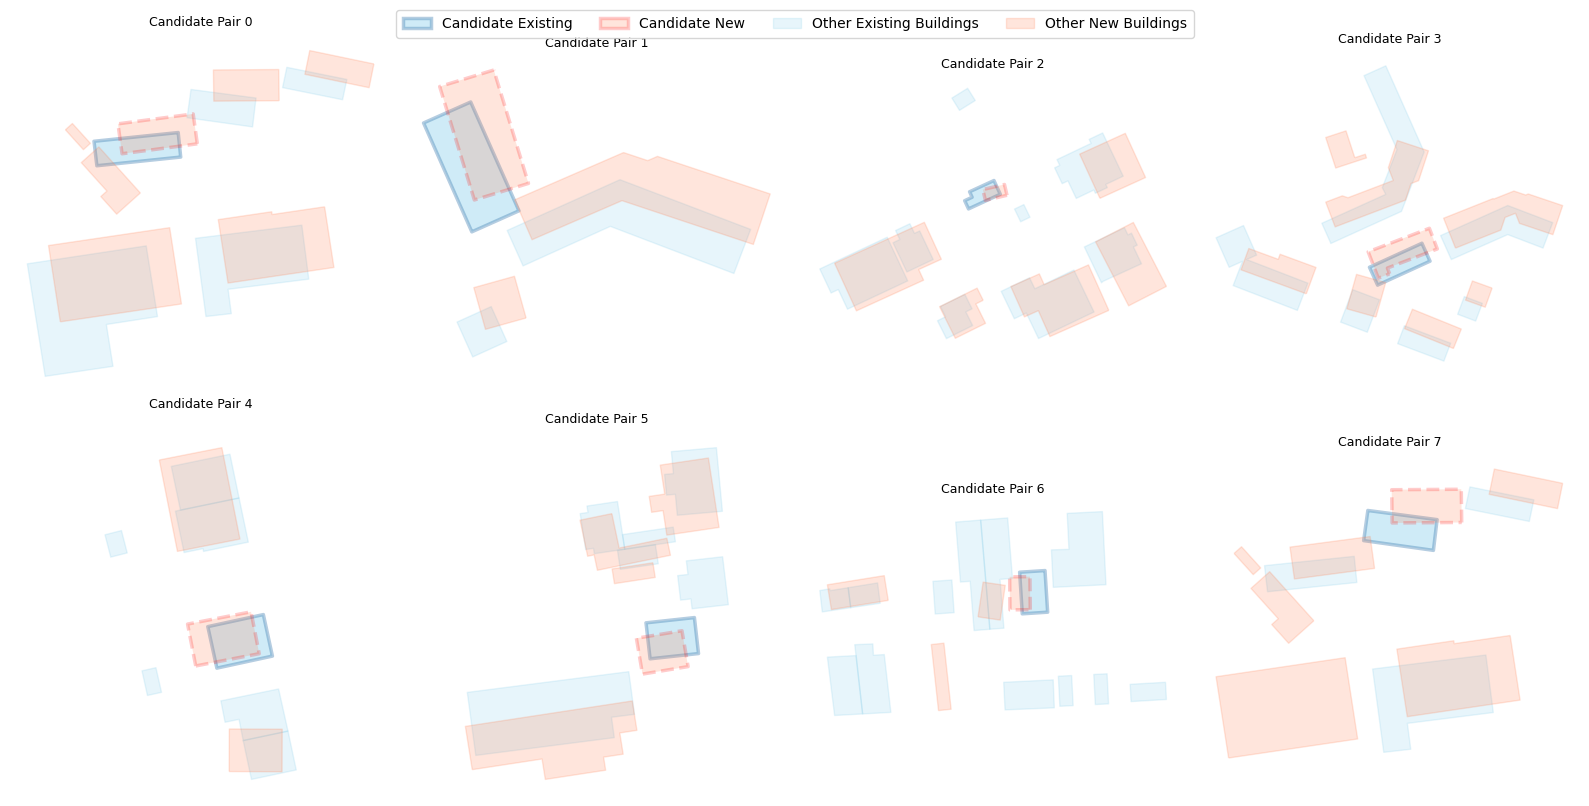

In [85]:
missed_matches = candidate_pairs[candidate_pairs['match_gt'] & ~candidate_pairs['match_iou']]

one_to_one_matches = candidate_pairs[candidate_pairs['match_gt']].drop_duplicates(subset=['datasets', 'id_new'], keep=False).drop_duplicates(subset=['datasets', 'id_existing'], keep=False)
misaligned = one_to_one_matches[~one_to_one_matches['match_iou'] & (one_to_one_matches['aligned_iou'] > 0.5)]
conservative = one_to_one_matches[~one_to_one_matches['match_iou'] & (one_to_one_matches['aligned_iou'] < 0.5)]

print(f"Share of one-to-one of missed matches: {len(one_to_one_matches[~one_to_one_matches['match_iou']]) / len(missed_matches):.2%}")
print(f"Missed matches due to conservative threshold: {len(conservative) / len(missed_matches):.2%}")
print(f"Missed matches due to misalignment: {len(misaligned) / len(missed_matches):.2%}")

many_to_many_matches = candidate_pairs[candidate_pairs['match_gt']].drop(one_to_one_matches.index)
many_to_many_matches.sort_values(['datasets', 'id_new'])


plot_map_grid(
    candidate_pairs=misaligned[misaligned['datasets'] == 'osm-msft'].sample(frac=1),
    existing_buildings=gdf_osm,
    new_buildings=gdf_msft,
    metrics=None,
    max_display=8,
)

### Differences in building footprint granularity

In [ ]:
from conflation.geoutil import dissolve_geometries_of_m_n_matches

agg_matches_osm_msft = dissolve_geometries_of_m_n_matches(candidate_pairs[candidate_pairs['match_gt'] & candidate_pairs['datasets'].isin(['osm-msft'])].rename(columns={'id_existing': 'building_id_1', 'id_new': 'building_id_2'}), gdf_osm, gdf_msft)
agg_matches_gov_msft = dissolve_geometries_of_m_n_matches(candidate_pairs[candidate_pairs['match_gt'] & candidate_pairs['datasets'].isin(['gov-msft'])].rename(columns={'id_existing': 'building_id_1', 'id_new': 'building_id_2'}), gdf_gov, gdf_msft)
agg_matches_gov_osm = dissolve_geometries_of_m_n_matches(candidate_pairs[candidate_pairs['match_gt'] & candidate_pairs['datasets'].isin(['gov-osm'])].rename(columns={'id_existing': 'building_id_1', 'id_new': 'building_id_2'}), gdf_gov, gdf_osm)


In [28]:
agg_matches_gov_msft['m:n'] = agg_matches_gov_msft['ids_1'].apply(len).clip(upper=4).astype(str) + ':' + agg_matches_gov_msft['ids_2'].apply(len).clip(upper=4).astype(str)
agg_matches_gov_msft['m:n'].value_counts(normalize=True).round(2)

agg_matches_gov_msft['m:n_agg'] = (agg_matches_gov_msft['ids_1'].apply(len).clip(upper=2).astype(str) + ':' + agg_matches_gov_msft['ids_2'].apply(len).clip(upper=2).astype(str)).replace({'1:2': '1:n', '2:1': 'm:1', '2:2': 'm:n'})
agg_matches_gov_msft['m:n_agg'].value_counts(normalize=True).round(2)

m:n_agg
1:1    0.67
m:1    0.24
1:n    0.06
m:n    0.02
Name: proportion, dtype: float64

In [36]:
agg_matches_gov_msft['ratio'] = agg_matches_gov_msft['ids_1'].apply(len) / agg_matches_gov_msft['ids_2'].apply(len)
agg_matches_gov_msft.explode('ids_1')['ratio'].mean()

np.float64(3.4552917192392165)

### Feature importance

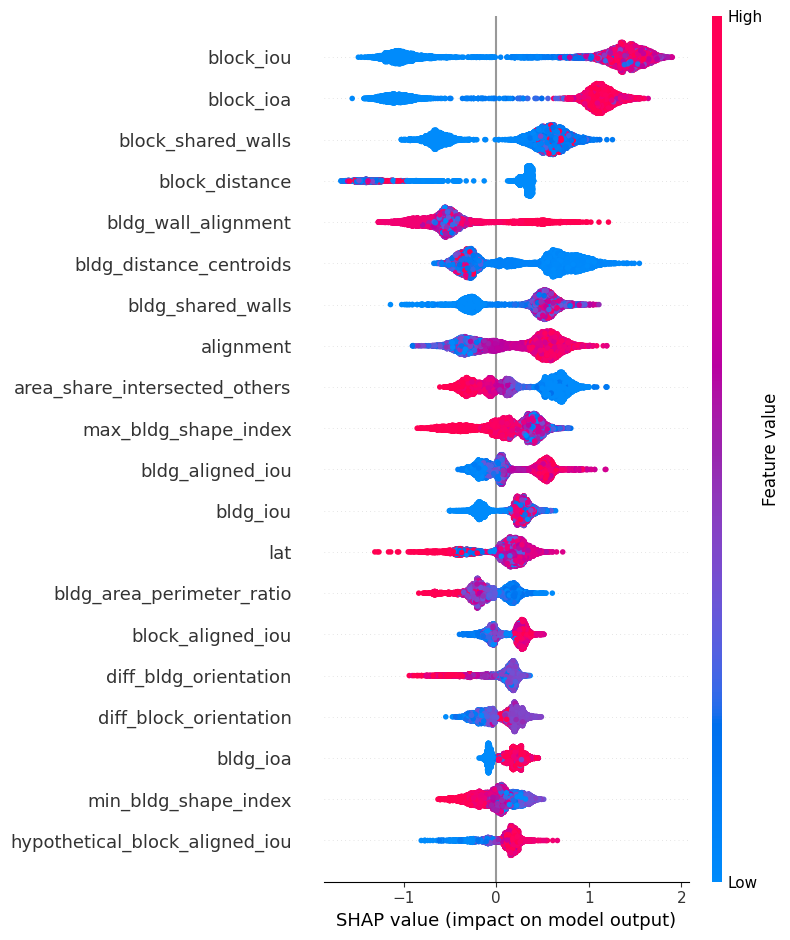

In [ ]:
XGBOOST_PARAMS = {'tree_method': 'hist', 'objective': 'binary:logistic'}
HYPERPARAMETERS = {
    'colsample_bytree': 0.7,
    'subsample': 0.7,
}

model_path = 'data/train/xgboost-model.json'
model = xgb.XGBClassifier(random_state=42, **HYPERPARAMETERS, **XGBOOST_PARAMS)
model.load_model(model_path)

fts = model.get_booster().feature_names
X_val = candidate_pairs[fts]

# Feature importance analysis on validation set
explainer = shap.Explainer(model)
X_val_cleaned = X_val.replace([np.inf, -np.inf], np.nan)
shap_values = explainer(X_val_cleaned)

shap.summary_plot(shap_values, X_val_cleaned, feature_names=fts)

### Group feature importance (Figure 3)

In [23]:
bldg_features = [
    'bldg_footprint_area',
    'bldg_perimeter',
    'bldg_corners',
    'bldg_longest_axis_length',
    'bldg_elongation',
    'bldg_orientation',
    'bldg_squareness',
    'bldg_convexity',
    'bldg_area_perimeter_ratio',
    'bldg_shape_index',
    'bldg_car_similarity',
    'min_bldg_shape_index',
    'max_bldg_shape_index',
]
block_features = [
    'block_footprint_area',
    'block_perimeter',
    'block_corners',
    'block_longest_axis_length',
    'block_elongation',
    'block_orientation',
    'block_squareness',
    'block_convexity',
    'block_area_perimeter_ratio',
    'block_shape_index',
    'block_length',
]

similarity_features = [
    'diff_bldg_footprint_area',
    'diff_bldg_perimeter',
    'diff_bldg_corners',
    'diff_bldg_longest_axis_length',
    'diff_bldg_elongation',
    'diff_bldg_orientation',
    'diff_bldg_squareness',
    'diff_bldg_convexity',
    'diff_bldg_area_perimeter_ratio',
    'diff_bldg_shape_index',
    'diff_bldg_car_similarity',
    'diff_block_footprint_area',
    'diff_block_perimeter',
    'diff_block_corners',
    'diff_block_longest_axis_length',
    'diff_block_elongation',
    'diff_block_orientation',
    'diff_block_squareness',
    'diff_block_convexity',
    'diff_block_area_perimeter_ratio',
    'diff_block_shape_index',
    'diff_block_length',
    'bldg_distance',
    'bldg_distance_centroids',
    'bldg_wall_alignment',
    'bldg_shared_walls',
    'bldg_shape_difference',
    'block_distance',
    'block_distance_centroids',
    'block_wall_alignment',
    'block_shared_walls',
    'block_shape_difference',
]
intersection_features = [
    'bldg_intersection',  # renamed to ioa
    'bldg_ioa',
    'bldg_aligned_ioa',  # renamed to iosa
    'bldg_iou',
    'bldg_aligned_iou',
    'block_intersection',  # renamed to ioa
    'block_ioa',  # renamed to iosa
    'block_aligned_ioa',  # renamed to iosa
    'block_iou',
    'block_aligned_iou',
]
context_features = [
    'n_intersecting',
    'area_share_intersected',
    'area_share_intersected_others',
    'agreement',
    'alignment',
    'shared_walls_neighbors',
    'n_intersecting_buffer_5',
    'n_intersecting_buffer_10',
    'n_intersecting_buffer_25',
    'n_intersecting_buffer_50',
    'hypothetical_block_distance',
    'hypothetical_block_distance_centroids',
    'hypothetical_block_intersection',
    'hypothetical_block_ioa',  # renamed to iosa
    'hypothetical_block_aligned_ioa',    # renamed to iosa
    'hypothetical_block_iou',
    'hypothetical_block_aligned_iou',
    'hypothetical_block_wall_alignment',
    'hypothetical_block_shared_walls',
    'lat',
    'lon'
]


def normalized_feature_importance(shap_values, feature_names):
    # Calculate feature importance based on SHAP values
    avg_shap_value = np.abs(shap_values).mean(0)
    normalized_shap_value = avg_shap_value / sum(avg_shap_value)

    feature_importance = pd.DataFrame(
        {'feature': feature_names, 'normalized_importance': normalized_shap_value})

    return feature_importance.sort_values(by=['normalized_importance'], ascending=False)


def aggregate_feature_importance(feature_importance, group_mapping):
    """
    Aggregate feature importance by groups defined in group_mapping.
    """
    reverse_group_mapping = {v: k for k,
                             values in group_mapping.items() for v in values}
    feature_importance['group'] = feature_importance['feature'].map(
        reverse_group_mapping)
    aggregated = feature_importance.groupby('group')['normalized_importance'].sum().reset_index()
    aggregated = aggregated.sort_values(by='normalized_importance', ascending=False)

    return aggregated


group_mapping = {
    'shape': bldg_features + block_features,
    'similarity': similarity_features,
    'intersection': intersection_features,
    'context': context_features,
}
feature_importance = normalized_feature_importance(shap_values.values, fts)
aggregated_importance = aggregate_feature_importance(feature_importance, group_mapping)
aggregated_importance.round(3)

,group,normalized_importance
3,similarity,0.376
1,intersection,0.266
0,context,0.200
2,shape,0.158


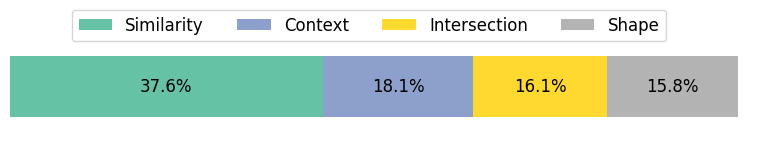

In [18]:
df_stacked = pd.DataFrame([aggregated_importance.set_index('group')['normalized_importance']]).rename(columns=lambda x: x.replace('_', ' ').title())
ax = df_stacked.plot.barh(stacked=True, figsize=(8, 1.7), cmap='Set2')
ax.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.47, 1.2), fontsize=12)
ax.set_axis_off()
for c in ax.containers:
        ax.bar_label(c, fmt=lambda x: f'{x:.1%}', label_type='center', fontsize=12)
plt.tight_layout()

plt.savefig('manuscript/feature_importance_groups.png', bbox_inches='tight', dpi=300)
plt.show()


### Threshold analysis

In [ ]:
# Define thresholds
threshold_values = np.arange(0.0, 1.05, 0.05)
metrics_to_evaluate = ['iou', 'iou_corrected', 'ioa', 'ioa_corrected', 'iosa', 'iosa_corrected']

# Prepare storage for results
f1_scores_pos = {metric: [] for metric in metrics_to_evaluate}
f1_scores_neg = {metric: [] for metric in metrics_to_evaluate}

# Compute F1 scores per threshold per metric
for threshold in threshold_values:
    for metric in metrics_to_evaluate:
        preds = candidate_pairs[metric] > threshold
        f1_pos = f1_score(candidate_pairs['match_gt'], preds, pos_label=True)
        f1_neg = f1_score(candidate_pairs['match_gt'], preds, pos_label=False)
        f1_scores_pos[metric].append(f1_pos)
        f1_scores_neg[metric].append(f1_neg)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for i, metric in enumerate(metrics_to_evaluate):
    ax.plot(threshold_values, f1_scores_pos[metric], linestyle='-', marker='o',
            color=colors[i], label=f'{metric} - Positive')
#     ax.plot(threshold_values, f1_scores_neg[metric], linestyle='--', marker='x',
#             color=colors[i], label=f'{metric} - Negative')

ax.set_title('F1 Score vs Classification Threshold', fontsize=16)
ax.set_xlabel('Classification Threshold', fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2, fontsize=11)
ax.grid(True)
plt.tight_layout()
plt.show()


## Spatial misalignment

In [35]:
candidate_pairs['corrected_misalignment'] = candidate_pairs['geometry_new'].centroid.distance(candidate_pairs['original_geometry_new'].centroid)
gdf = pd.concat([gdf_gov, gdf_osm, gdf_msft], ignore_index=False, keys=['gov', 'osm', 'msft']).reset_index(level=0).rename(columns={'level_0': 'dataset'})
candidate_pairs['neighborhood'] = candidate_pairs['id_new'].map(gdf['neighborhood'])
nbhs = candidate_pairs.drop_duplicates('id_new').groupby(['neighborhood'])['corrected_misalignment'].mean().sort_values(ascending=False)

(nbhs > 3).mean()

np.float64(0.1702127659574468)

## Analysis of example neighborhood (Figure 2)

In [ ]:
nbh = '89089ec9c2fffff'
pairs_nbh = candidate_pairs[(candidate_pairs['datasets'] == 'gov-msft') & (candidate_pairs['neighborhood'] == nbh)]
m = pairs_nbh.set_geometry('geometry_new').explore('iosa', tiles='cartodbpositron', style_kwds={"fillOpacity": 0.3, 'weight': 2})
m = pairs_nbh.set_geometry('original_geometry_new').explore(color='coral', m=m, tiles='cartodbpositron', style_kwds={"fillOpacity": 0, 'weight': 2})

# Illustrate correction of misalignment
# for idx, row in pairs_nbh.iterrows():
#     # .to_crs('EPSG:4326')
#     folium.PolyLine(
#         locations=[(row['geometry_new'].centroid.y, row['geometry_new'].centroid.x), (row['original_geometry_new'].centroid.y, row['original_geometry_new'].centroid.x)],
#         color='blue',
#         weight=4,
#         opacity=0.8,
#         # dash_array='5, 5',
#     ).add_to(m)
m
# m = existing_building.reset_index().explore(m=m, color='steelblue', style_kwds={"fillOpacity": 0.4, 'weight': 5})
#         m = new_building.reset_index().explore(m=m, color='orangered', style_kwds={"fillOpacity": 0.2, 'weight': 4})


## Merging

### Missings and duplicates (Table 3)

In [ ]:
unique = candidate_pairs.groupby(['id_new', 'dataset'])['match_gt'].any()
added_building_count = unique[~unique].reset_index()['dataset'].value_counts()
added_share = added_building_count / candidate_pairs.groupby('dataset')['id_existing'].nunique()
added_share

dataset
gov-msft    0.118674
gov-osm     0.041150
osm-msft    0.374521
dtype: float64

In [45]:
def print_dups_missings_stats(added_buildings, duplicates, full_duplicates, missings, metric):
    full_duplicate_share = full_duplicates.nunique() / len(set(added_buildings).union(duplicates))
    duplicate_share = duplicates.nunique() / len(set(added_buildings).union(duplicates))
    missings_share = len(missings) / len(added_buildings)
    
    print(f'Missings share for metric "{metric}": {missings_share:.1%}')
    print(f'Duplicate share for metric "{metric}": {duplicate_share:.1%}')
    print(f'1:1 Duplicate share for metric "{metric}": {full_duplicate_share:.1%}')

conflation_pairs = {
    'gov-osm': (gdf_gov, gdf_osm),
    'gov-msft': (gdf_gov, gdf_msft),
    'osm-msft': (gdf_osm, gdf_msft)
}

for dataset, (gdf1, gdf2) in conflation_pairs.items():
    pairs = candidate_pairs[candidate_pairs['datasets'] == dataset]
    pairs['intersecting_any'] = intersecting(pairs['original_geometry_new'], gdf1)
    pairs['intersecting_above'] = intersecting_above(pairs['original_geometry_new'], gdf1, threshold=0.2)

    matches = pairs.groupby('id_new')['match_gt'].any()
    one_to_one_matches = pairs[pairs['match_gt'] & (pairs['block_length'] == 1)]
    added_buildings = matches[~matches].index

    print(f'\n======== {dataset} ========')

    # XGBoost 
    metric = 'XGBoost'
    full_duplicates = one_to_one_matches[~one_to_one_matches['match_xgb']]['id_new']
    duplicates = pairs[pairs['match_gt'] & ~pairs['match_xgb']]['id_new']
    missings = pairs[pairs['match_xgb'] & pairs['id_new'].isin(added_buildings)]

    print_dups_missings_stats(added_buildings, duplicates, full_duplicates, missings, metric)


    # No Intersection 
    metric = 'No Intersection'
    full_duplicates = one_to_one_matches[~one_to_one_matches['intersecting_any']]['id_new']
    duplicates = pairs[pairs['match_gt'] & ~pairs['intersecting_any']]['id_new']
    missings = pairs[(pairs['ioa'] > 0) & pairs['id_new'].isin(added_buildings)]

    print_dups_missings_stats(added_buildings, duplicates, full_duplicates, missings, metric)


    # Slight Intersection 
    metric = '0.2 Intersection'
    full_duplicates = one_to_one_matches[~one_to_one_matches['intersecting_above']]['id_new']
    duplicates = pairs[pairs['match_gt'] & ~pairs['intersecting_above']]['id_new']
    missings = pairs[(pairs['ioa'] > 0.2) & pairs['id_new'].isin(added_buildings)]

    print_dups_missings_stats(added_buildings, duplicates, full_duplicates, missings, metric)


======== gov-osm ========
Missings share for metric "XGBoost": 2.2%
Duplicate share for metric "XGBoost": 4.1%
1:1 Duplicate share for metric "XGBoost": 0.0%
Missings share for metric "No Intersection": 1.1%
Duplicate share for metric "No Intersection": 23.1%
1:1 Duplicate share for metric "No Intersection": 1.7%
Missings share for metric "0.2 Intersection": 0.0%
Duplicate share for metric "0.2 Intersection": 43.6%
1:1 Duplicate share for metric "0.2 Intersection": 2.4%

======== gov-msft ========
Missings share for metric "XGBoost": 1.8%
Duplicate share for metric "XGBoost": 0.4%
1:1 Duplicate share for metric "XGBoost": 0.0%
Missings share for metric "No Intersection": 2.2%
Duplicate share for metric "No Intersection": 11.4%
1:1 Duplicate share for metric "No Intersection": 2.3%
Missings share for metric "0.2 Intersection": 0.0%
Duplicate share for metric "0.2 Intersection": 26.7%
1:1 Duplicate share for metric "0.2 Intersection": 7.3%

======== osm-msft ========
Missings share for 

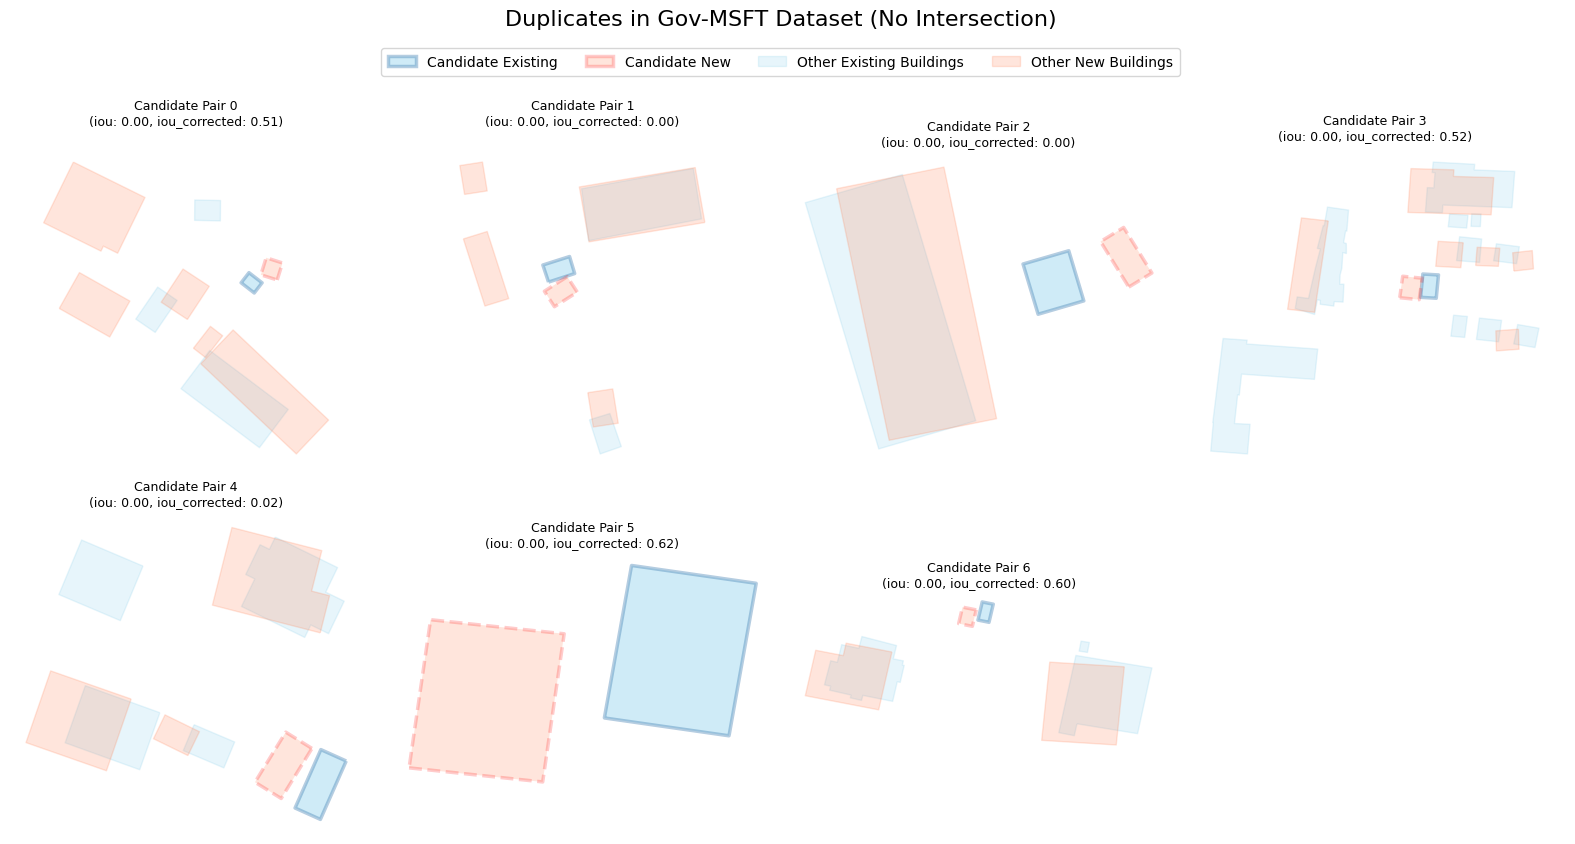

In [44]:
dataset_pairs = candidate_pairs[candidate_pairs['datasets'] == 'gov-msft']
dataset_pairs['intersecting_any'] = intersecting(dataset_pairs['original_geometry_new'], gdf_gov)

one_to_one_matches = dataset_pairs[dataset_pairs['match_gt'] & (dataset_pairs['block_length'] == 1)]
# duplicates = dataset_pairs[dataset_pairs['match_gt'] & ~dataset_pairs['match_xgb']]
duplicates = dataset_pairs[dataset_pairs['match_gt'] & ~dataset_pairs['intersecting_any']]
full_duplicates = one_to_one_matches[~one_to_one_matches['intersecting_any']]

plot_map_grid(
    full_duplicates.sample(frac=1),
    gdf_gov,
    gdf_msft,
    metrics=['iou', 'iou_corrected'],
    max_display=8,
    title='Duplicates in Gov-MSFT Dataset (No Intersection)',
)

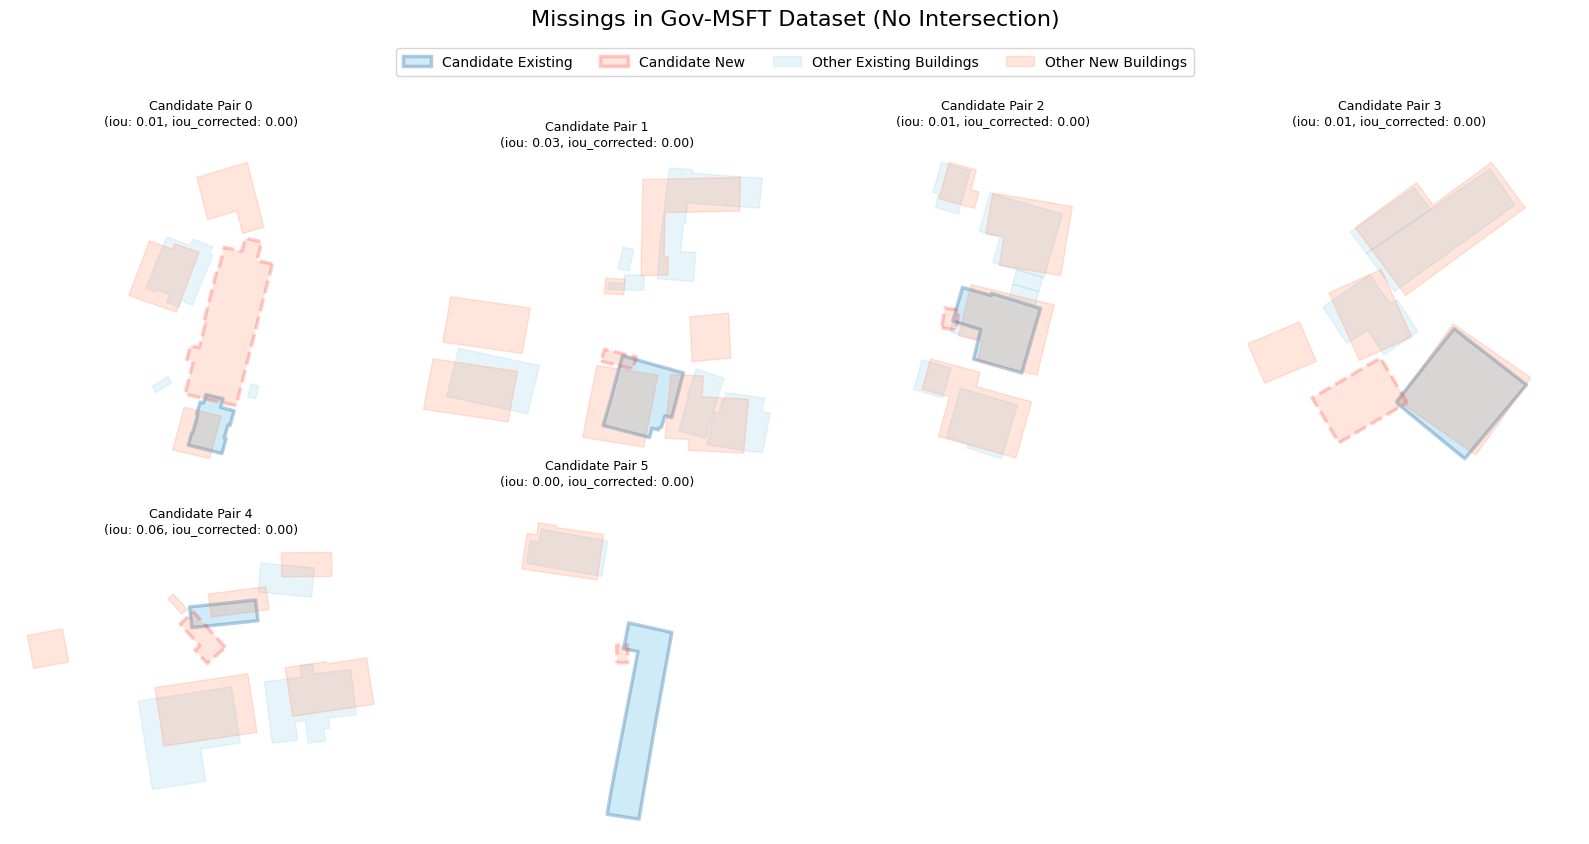

In [50]:

dataset_pairs = candidate_pairs[candidate_pairs['datasets'] == 'gov-msft']
matches = dataset_pairs.groupby('id_new')['match_gt'].any()
one_to_one_matches = dataset_pairs[dataset_pairs['match_gt'] & (dataset_pairs['block_length'] == 1)]
added_buildings = matches[~matches].index
missings = dataset_pairs[(dataset_pairs['ioa'] > 0.0) & dataset_pairs['id_new'].isin(added_buildings)]

# gray polygon indicates geometry after shift correction
plot_map_grid(
    missings.sample(frac=1),
    gdf_gov,
    gdf_msft,
    metrics=['iou', 'iou_corrected'],
    max_display=8,
    title='Missings in Gov-MSFT Dataset (No Intersection)',
)

### Attribute merging (Table 4)

In [ ]:
# Number of reference pairs for evaluating attribute merging precision
candidate_pairs[candidate_pairs['match_gt']].dropna(subset=['height', 'matched_height']).value_counts('datasets')

datasets
gov-msft    929
osm-msft    436
gov-osm     221
Name: count, dtype: int64

In [ ]:
gdf = pd.concat([gdf_gov, gdf_osm, gdf_msft], ignore_index=False)
candidate_pairs = candidate_pairs.merge(gdf[['height', 'type', 'age']], left_on='id_existing', right_index=True)
candidate_pairs = candidate_pairs.merge(gdf[['height', 'type', 'age']].add_prefix('matched_'), left_on='id_new', right_index=True)

metrics_matching = ['iou', 'iosa', 'ioa', 'xgb']
for metric in metrics_matching:
    print(f'\n======== Evaluation of metric "{metric}" ========')
    matched_pairs_gt = candidate_pairs[candidate_pairs['match_gt']].copy()
    matched_pairs = candidate_pairs[candidate_pairs[f'match_{metric}']].copy()
    
    print("\n---- Height Evaluation ----")
    for group in ['gov-osm', 'gov-msft', 'osm-msft']:

        print(f"\nEvaluating group: {group}")
        dataset_pairs_gt = matched_pairs_gt[matched_pairs_gt['datasets'] == group]
        dataset_pairs = matched_pairs[matched_pairs['datasets'] == group]
        eval_pairs = dataset_pairs.dropna(subset=['height', 'matched_height'])
        mae = metrics.mean_absolute_error(eval_pairs['height'], eval_pairs['matched_height'])
        rmse = metrics.root_mean_squared_error(eval_pairs['height'], eval_pairs['matched_height'])

        print(f"N: {len(eval_pairs)}")
        print(f"Share: {dataset_pairs['matched_height'].notna().sum() / dataset_pairs_gt['matched_height'].notna().sum():.1%}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")


    dataset_pairs = matched_pairs[matched_pairs['datasets'] == 'gov-osm']
    dataset_pairs_gt = matched_pairs_gt[matched_pairs_gt['datasets'] == 'gov-osm']
    eval_pairs = dataset_pairs.dropna(subset=['type', 'matched_type'])
    f1 = metrics.f1_score(eval_pairs['type'], eval_pairs['matched_type'], average='weighted')

    print("\n---- Type Evaluation ----")
    print(f"N: {len(eval_pairs)}")
    print(f"Share: {dataset_pairs['matched_type'].notna().sum() / dataset_pairs_gt['matched_type'].notna().sum():.1%}")
    print(f"F1 Score (weighted): {f1:.2f}")

    eval_pairs = dataset_pairs.dropna(subset=['age', 'matched_age'])
    mae = metrics.mean_absolute_error(eval_pairs['age'], eval_pairs['matched_age'])
    rmse = metrics.root_mean_squared_error(eval_pairs['age'], eval_pairs['matched_age'])

    print("\n---- Age Evaluation ----")
    print(f"N: {len(eval_pairs)}")
    print(f"Share: {dataset_pairs['matched_age'].notna().sum() / dataset_pairs_gt['matched_age'].notna().sum():.1%}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")


======== iou Evaluation ========

---- Height Evaluation ----

Evaluating group: gov-osm
N: 217
Share: 98.7%
Mean Absolute Error: 0.31
Root Mean Squared Error: 1.14

Evaluating group: gov-msft
N: 321
Share: 35.4%
Mean Absolute Error: 2.65
Root Mean Squared Error: 3.92

Evaluating group: osm-msft
N: 125
Share: 37.2%
Mean Absolute Error: 1.86
Root Mean Squared Error: 4.09

---- Type Evaluation ----
N: 264
Share: 64.0%
F1 Score (weighted): 0.98

---- Age Evaluation ----
N: 123
Share: 95.4%
Mean Absolute Error: 0.91
Root Mean Squared Error: 2.27

======== ioa Evaluation ========

---- Height Evaluation ----

Evaluating group: gov-osm
N: 220
Share: 99.7%
Mean Absolute Error: 0.34
Root Mean Squared Error: 1.21

Evaluating group: gov-msft
N: 836
Share: 90.0%
Mean Absolute Error: 3.41
Root Mean Squared Error: 5.14

Evaluating group: osm-msft
N: 382
Share: 88.3%
Mean Absolute Error: 3.08
Root Mean Squared Error: 5.60

---- Type Evaluation ----
N: 389
Share: 94.7%
F1 Score (weighted): 0.96

---

In [ ]:
# Initialize results list
results = []

metrics_matching = ['iou', 'iosa', 'ioa', 'xgb', 'gt']

for metric in metrics_matching:
    matched_pairs_gt = candidate_pairs[candidate_pairs['match_gt']].copy()
    matched_pairs = candidate_pairs[candidate_pairs[f'match_{metric}']].copy()
    
    # Height: gov-osm and gov-msft
    for group in ['gov-osm', 'gov-msft']:
        dataset_pairs_gt = matched_pairs_gt[matched_pairs_gt['datasets'] == group]
        dataset_pairs = matched_pairs[matched_pairs['datasets'] == group]
        eval_pairs = dataset_pairs.dropna(subset=['height', 'matched_height'])
        share = dataset_pairs['matched_height'].notna().sum() / dataset_pairs_gt['matched_height'].notna().sum()
        mae = metrics.mean_absolute_error(eval_pairs['height'], eval_pairs['matched_height'])

        results.append({
            'metric': metric,
            'attribute': 'aaa-height',
            'dataset': group,
            'share': round(share, 2),
            'score': round(mae, 1),
            'score_type': 'MAE'
        })

    # Type: gov-osm only
    group = 'gov-osm'
    dataset_pairs_gt = matched_pairs_gt[matched_pairs_gt['datasets'] == group]
    dataset_pairs = matched_pairs[matched_pairs['datasets'] == group]
    eval_pairs = dataset_pairs.dropna(subset=['type', 'matched_type'])
    share = dataset_pairs['matched_type'].notna().sum() / dataset_pairs_gt['matched_type'].notna().sum()
    f1 = metrics.f1_score(eval_pairs['type'], eval_pairs['matched_type'], average='weighted')

    results.append({
        'metric': metric,
        'attribute': 'type',
        'dataset': group,
        'share': round(share, 2),
        'score': round(f1, 2),
        'score_type': 'F1'
    })

    # Age: gov-osm only
    eval_pairs = dataset_pairs.dropna(subset=['age', 'matched_age'])
    share = dataset_pairs['matched_age'].notna().sum() / dataset_pairs_gt['matched_age'].notna().sum()
    mae = metrics.mean_absolute_error(eval_pairs['age'], eval_pairs['matched_age'])

    results.append({
        'metric': metric,
        'attribute': 'age',
        'dataset': group,
        'share': round(share, 2),
        'score': round(mae, 1),
        'score_type': 'MAE'
    })

# Create summary table
df = pd.DataFrame(results)
df_pivot = df.pivot_table(
    index='metric',
    columns=['attribute', 'dataset'],
    values=['share', 'score'],
    aggfunc='first'
)
df_pivot.columns = df_pivot.columns.swaplevel(0, 2)
df_pivot = df_pivot.sort_index(axis=1, level=[0, 1], ascending=False)  # optional: sort neatly

df_pivot.to_latex(
    'manuscript/attribute_enrichment.tex',
    float_format="%.2f",
    column_format="l" + "r" * (len(df_pivot.columns)),
    bold_rows=True,
    caption="Performance of Matching Metrics by Dataset",
    label="tab:attribute_enrichment"
)
df_pivot


dataset      gov-osm                                      gov-msft      
attribute       type         age       aaa-height       aaa-height      
               share score share score      share score      share score
metric                                                                  
gt              1.00  0.96  1.00   1.1       1.00   0.4       1.00   3.4
intersection    0.84  0.97  0.96   0.9       0.99   0.3       0.85   3.3
ioa             0.95  0.96  0.96   0.9       1.00   0.3       0.90   3.4
iou             0.64  0.98  0.95   0.9       0.99   0.3       0.35   2.6
xgb             1.00  0.96  1.00   1.1       1.00   0.4       1.00   3.4

### Estimation of dataset overlaps (Figure 4)

Gov IDs: 2454
OSM IDs: 3195
MSFT IDs: 3153
Gov-OSM matches: 2102
OSM-MSFT matches: 2936
Gov-MSFT matches: 2187
Gov IDs: 2454
OSM IDs: 3268
MSFT IDs: 4098
Footprint areas - Gov: 0.43 km²
Footprint areas - OSM: 0.55 km²
Footprint areas - MSFT: 0.65 km²


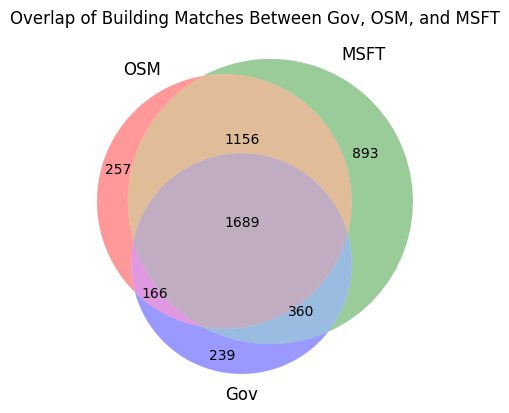

In [72]:
# all regions
gov_ids = set(gdf_gov.index.unique())
osm_ids = set(gdf_osm.index.unique())
msft_ids = set(gdf_msft.index.unique())
# gov_ids = set(candidate_pairs[candidate_pairs['id_existing'].str.contains('gov')]['id_existing'])
# osm_ids = set(candidate_pairs[candidate_pairs['id_existing'].str.contains('osm')]['id_existing']).union(
#            candidate_pairs[candidate_pairs['id_new'].str.contains('osm')]['id_new'])
# msft_ids = set(candidate_pairs[candidate_pairs['id_new'].str.contains('msft')]['id_new'])

# only gov regions
# candidate_pairs['region'] = candidate_pairs['id_new'].str.split('_').str[0]
# gov_regions = candidate_pairs[candidate_pairs['id_existing'].str.contains('gov')]['region'].unique()
# gov_ids = set(candidate_pairs[candidate_pairs['id_existing'].str.contains('gov')]['id_existing'])
# osm_ids = set(candidate_pairs[candidate_pairs['id_existing'].str.contains('osm') & candidate_pairs['region'].isin(gov_regions)]['id_existing']).union(
#            candidate_pairs[candidate_pairs['id_new'].str.contains('osm') & candidate_pairs['region'].isin(gov_regions)]['id_new'])
# msft_ids = set(candidate_pairs[candidate_pairs['id_new'].str.contains('msft') & candidate_pairs['region'].isin(gov_regions)]['id_new'])

print(f"Gov IDs: {len(gov_ids)}")
print(f"OSM IDs: {len(osm_ids)}")
print(f"MSFT IDs: {len(msft_ids)}")

gov_osm_matches = candidate_pairs[(candidate_pairs['datasets'] == 'gov-osm') & candidate_pairs['match_gt']]
print(f"Gov-OSM matches: {len(gov_osm_matches)}")
osm_ids -= set(gov_osm_matches['id_new'])
osm_ids |= set(gov_osm_matches['id_existing'])

osm_msft_matches = candidate_pairs[(candidate_pairs['datasets'] == 'osm-msft') & candidate_pairs['match_gt']]
print(f"OSM-MSFT matches: {len(osm_msft_matches)}")
msft_ids -= set(osm_msft_matches['id_new'])
msft_ids |= set(osm_msft_matches['id_existing'].replace(gov_osm_matches.set_index('id_new')['id_existing']))

gov_msft_matches = candidate_pairs[(candidate_pairs['datasets'] == 'gov-msft') & candidate_pairs['match_gt']]
print(f"Gov-MSFT matches: {len(gov_msft_matches)}")
msft_ids -= set(gov_msft_matches['id_new'])
msft_ids |= set(gov_msft_matches['id_existing'])


print(f"Gov IDs: {len(gov_ids)}")
print(f"OSM IDs: {len(osm_ids)}")
print(f"MSFT IDs: {len(msft_ids)}")

print(f"Footprint areas - Gov: {gdf.loc[list(gov_ids)].drop_duplicates(subset='id').area.sum() / 1e6:.2f} km²")
print(f"Footprint areas - OSM: {gdf.loc[list(osm_ids)].drop_duplicates(subset='id').area.sum() / 1e6:.2f} km²")
print(f"Footprint areas - MSFT: {gdf.loc[list(msft_ids)].drop_duplicates(subset='id').area.sum() / 1e6:.2f} km²")

# Prepare Venn areas
venn3(
    subsets = (osm_ids, msft_ids, gov_ids),
    set_labels=('OSM', 'MSFT', 'Gov'),
)

plt.title("Overlap of Building Matches Between Gov, OSM, and MSFT")
plt.show()


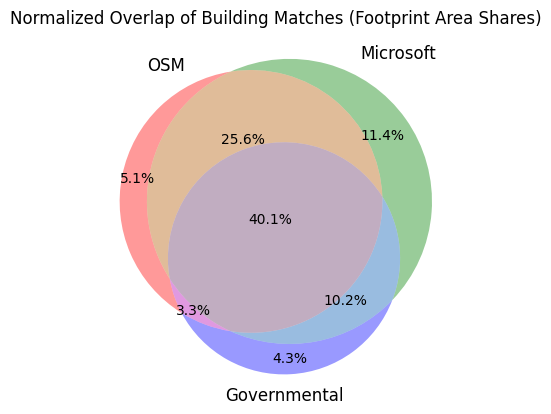

In [74]:
# Combine sets to get total unique IDs
all_ids = gov_ids | osm_ids | msft_ids
total = len(all_ids)
total_footprint_area = gdf.loc[list(all_ids)].drop_duplicates(subset='id').area.sum() 

# Calculate intersections
only_osm = osm_ids - msft_ids - gov_ids
only_msft = msft_ids - osm_ids - gov_ids
only_gov = gov_ids - osm_ids - msft_ids

osm_msft = osm_ids & msft_ids - gov_ids
osm_gov = osm_ids & gov_ids - msft_ids
msft_gov = msft_ids & gov_ids - osm_ids

all_three = osm_ids & msft_ids & gov_ids

# Convert counts to shares
shares = {
    '100': round(len(only_osm) / total, 3),
    '010': round(len(only_msft) / total, 3),
    '001': round(len(only_gov) / total, 3),
    '110': round(len(osm_msft) / total, 3),
    '101': round(len(osm_gov) / total, 3),
    '011': round(len(msft_gov) / total, 3),
    '111': round(len(all_three) / total, 3),
}

footprint_shares = {
    '100': gdf.loc[list(only_osm)].drop_duplicates(subset='id').area.sum() / total_footprint_area,
    '010': gdf.loc[list(only_msft)].drop_duplicates(subset='id').area.sum() / total_footprint_area,
    '001': gdf.loc[list(only_gov)].drop_duplicates(subset='id').area.sum() / total_footprint_area,
    '110': gdf.loc[list(osm_msft)].drop_duplicates(subset='id').area.sum() / total_footprint_area,
    '101': gdf.loc[list(osm_gov)].drop_duplicates(subset='id').area.sum() / total_footprint_area,
    '011': gdf.loc[list(msft_gov)].drop_duplicates(subset='id').area.sum() / total_footprint_area,
    '111': gdf.loc[list(all_three)].drop_duplicates(subset='id').area.sum() / total_footprint_area,
}

# Plot normalized Venn diagram
venn3(subsets=footprint_shares, set_labels=('OSM', 'Microsoft', 'Governmental'), subset_label_formatter=lambda x: format(x, ".1%"),)

plt.title("Normalized Overlap of Building Matches (Footprint Area Shares)")
# plt.savefig('manuscript/venn_diagram.png', bbox_inches='tight', dpi=300)
plt.show()